<a href="https://colab.research.google.com/github/Sarthi-Malavalia/projects/blob/main/cephelometric_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/college/cephalometry",
    labels='inferred',  # Important for 3 classes
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 379 files belonging to 3 classes.
Using 304 files for training.
Using 75 files for validation.


In [4]:
#or
'''
import tensorflow as tf
from tensorflow import keras

image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "celphalometry",
    labels='inferred',
    validation_split=0.2,
    subset="both",
    seed=1337,
    batch_size=batch_size,
)

# Dynamic resizing using Resizing layer
train_ds = train_ds.map(lambda x, y: (tf.keras.layers.Resizing(image_size[0], image_size[1])(x), y))
val_ds = val_ds.map(lambda x, y: (tf.keras.layers.Resizing(image_size[0], image_size[1])(x), y))
'''

'\nimport tensorflow as tf\nfrom tensorflow import keras\n\nimage_size = (180, 180)\nbatch_size = 128\n\ntrain_ds, val_ds = keras.utils.image_dataset_from_directory(\n    "celphalometry",\n    labels=\'inferred\',\n    validation_split=0.2,\n    subset="both",\n    seed=1337,\n    batch_size=batch_size,\n)\n\n# Dynamic resizing using Resizing layer\ntrain_ds = train_ds.map(lambda x, y: (tf.keras.layers.Resizing(image_size[0], image_size[1])(x), y))\nval_ds = val_ds.map(lambda x, y: (tf.keras.layers.Resizing(image_size[0], image_size[1])(x), y))\n'

In [5]:
# alternative
'''
import tensorflow as tf
from tensorflow import keras

image_size = (180, 180)
batch_size = 128

def resize_image(image, label):
    resized_image = tf.image.resize(image, image_size)
    return resized_image, label

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "celphalometry",
    labels='inferred',
    validation_split=0.2,
    subset="both",
    seed=1337,
    batch_size=batch_size,
)

# Apply custom preprocessing function
train_ds = train_ds.map(resize_image)
val_ds = val_ds.map(resize_image)
'''

'\nimport tensorflow as tf\nfrom tensorflow import keras\n\nimage_size = (180, 180)\nbatch_size = 128\n\ndef resize_image(image, label):\n    resized_image = tf.image.resize(image, image_size)\n    return resized_image, label\n\ntrain_ds, val_ds = keras.utils.image_dataset_from_directory(\n    "celphalometry",\n    labels=\'inferred\',\n    validation_split=0.2,\n    subset="both",\n    seed=1337,\n    batch_size=batch_size,\n)\n\n# Apply custom preprocessing function\ntrain_ds = train_ds.map(resize_image)\nval_ds = val_ds.map(resize_image)\n'

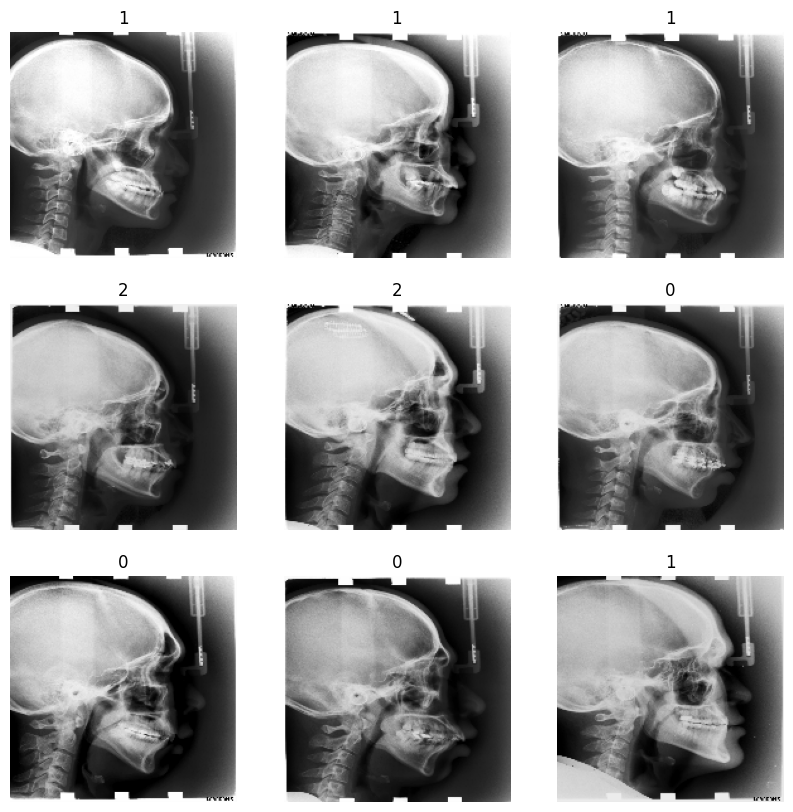

In [6]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:

data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

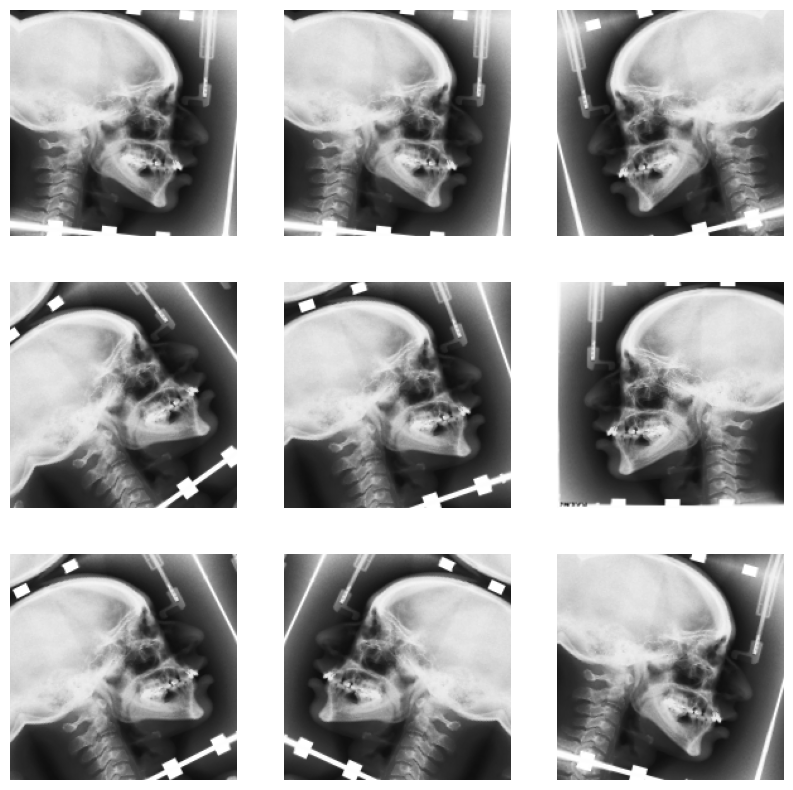

In [8]:

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [9]:

# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

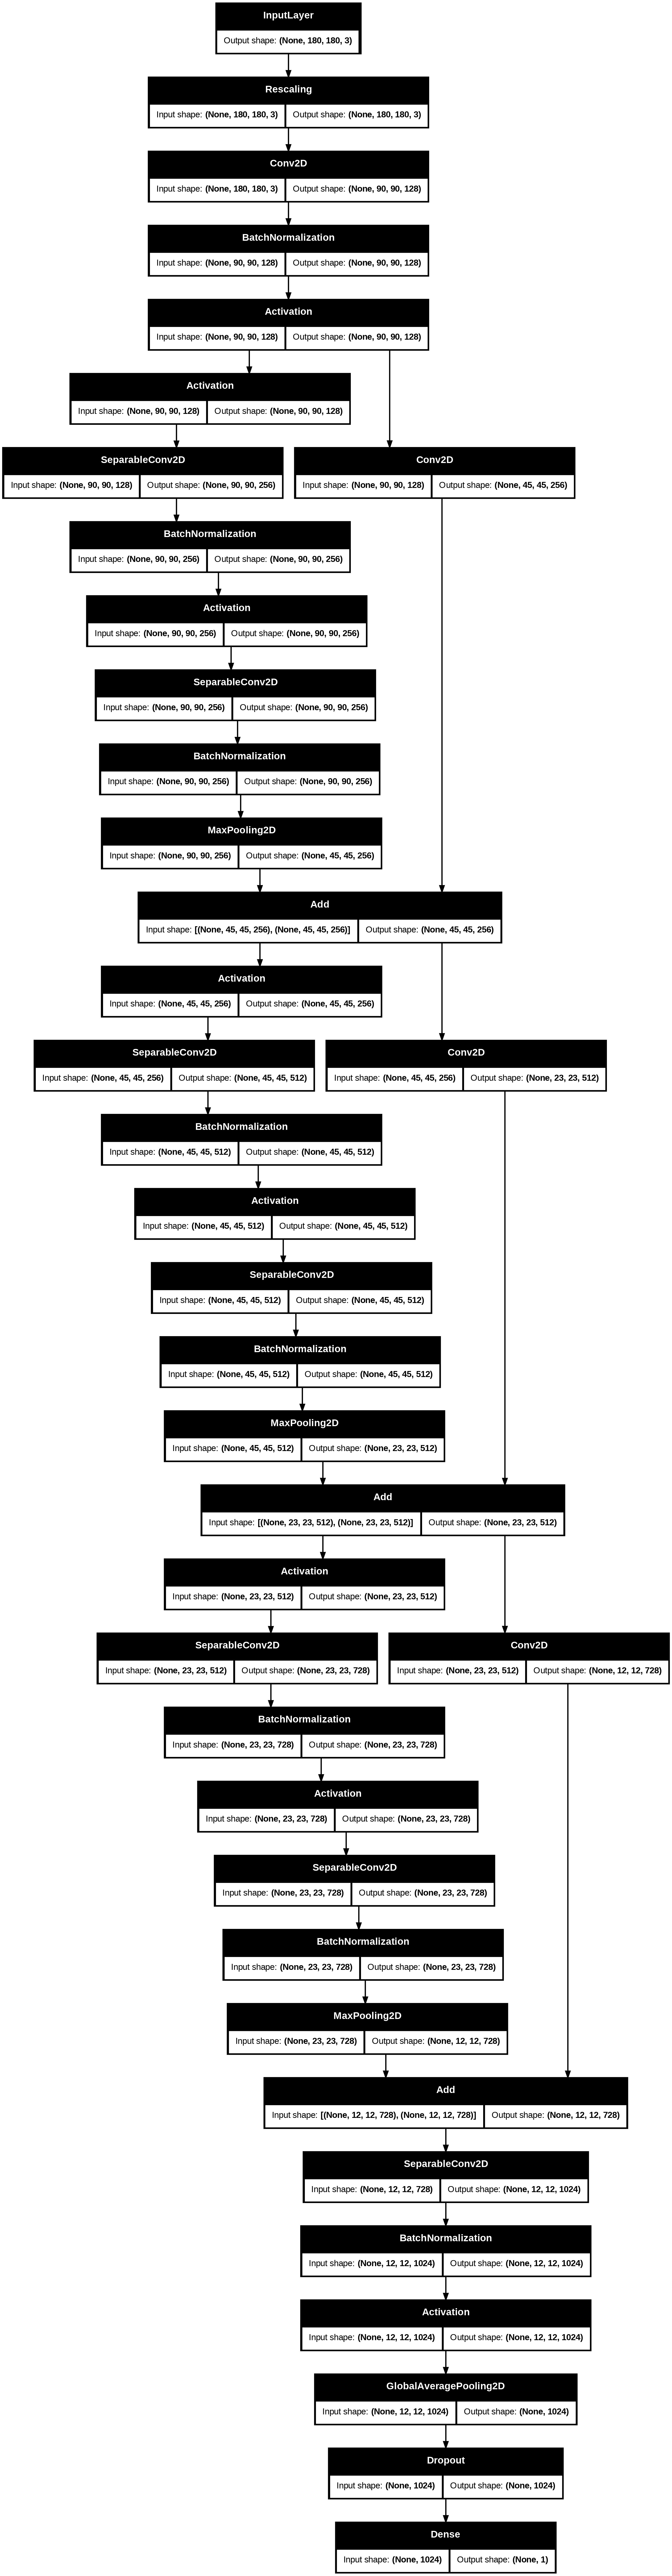

In [10]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


In [18]:
from tensorflow.keras.models import load_model
if os.path.exists('/content/drive/MyDrive/my_model.keras'):

  model = load_model('/content/drive/MyDrive/my_model.keras')
  print("Model loaded from drive.")


  # Load the weights separately (if needed)
  #model.load_weights("model_weights.h5")
  #model.compile_metrics

else:
  # File doesn't exist, create a new model (or handle the situation accordingly)
  print("Model not found in drive, creating a new one.")

  """
  ## Train the model
  """

  epochs = 50

  callbacks = [
      keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
  ]
  model.compile(
      optimizer=keras.optimizers.Adam(3e-4),
      loss=keras.losses.BinaryCrossentropy(from_logits=True),
      metrics=[keras.metrics.BinaryAccuracy(name="acc")],
  )
  model.fit(
      train_ds,
      epochs=epochs,
      callbacks=callbacks,
      validation_data=val_ds,
  )





Model loaded from drive.


In [17]:

# Save the entire model including architecture and weights
model.save('/content/drive/MyDrive/my_model.keras')

# Alternatively, save only the model weights
# model.save_weights('/content/drive/MyDrive/my_model_weights.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
This image is 19.92% Concave.
This image is 22.03% Convex.
This image is 18.98% Plane.
The predicted class is: Convex


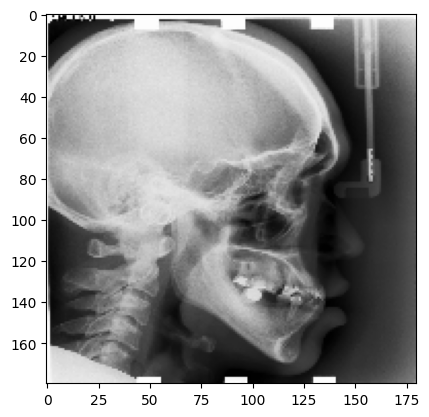

In [39]:
# Load and display the image
# Update the path to the actual location of your image
img_path = "/content/drive/MyDrive/college/cephalometry/Concave/001.jpg"  # Replace '001.jpg' with the actual image file name and adjust 'Concave' if needed
img = keras.utils.load_img(img_path, target_size=image_size)
plt.imshow(img)

# Prepare the image for prediction
img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class probabilities
class_probabilities = predictions[0]  # This will be an array of probabilities for each class

# Display the probabilities for each class
class_labels = ['Concave', 'Convex', 'Plane']
for i, class_name in enumerate(class_labels):
    print(f"This image is {100 * class_probabilities[i]:.2f}% {class_name}.")

print(f"The predicted class is: {predicted_class_name}")

In [20]:
# prompt: show me the accuracy metrics

import numpy as np

# Assuming 'history' object is available from model.fit()
# history = model.fit(...)

# Access accuracy metrics
# Replace with your actual history object if different
# Assuming history contains 'acc' and 'val_acc'
# accuracy = history.history['acc']
# val_accuracy = history.history['val_acc']


# Example: Calculate and print the final accuracy values
# print(f"Final Training Accuracy: {accuracy[-1]:.4f}")
# print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")


# Example: Calculate and print other relevant metrics
# Assuming history also contains loss, val_loss
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# print(f"Final Training Loss: {loss[-1]:.4f}")
# print(f"Final Validation Loss: {val_loss[-1]:.4f}")

# You can also plot the metrics over the epochs:
# import matplotlib.pyplot as plt
# plt.plot(accuracy, label='Training Accuracy')
# plt.plot(val_accuracy, label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


In [27]:
# prompt: write code to show the accuracy of the model out of 100

# Assuming 'history' object is available from model.fit()
# history = model.fit(...)

# Access accuracy metrics
# Replace with your actual history object if different
# Assuming history contains 'acc' and 'val_acc'
if 'history' in locals():
  accuracy = history.history['acc']
  val_accuracy = history.history['val_acc']

  # Example: Calculate and print the final accuracy values
  print(f"Final Training Accuracy: {accuracy[-1]:.4f}")
  print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")

  # Example: Calculate and print other relevant metrics
  # Assuming history also contains loss, val_loss
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  print(f"Final Training Loss: {loss[-1]:.4f}")
  print(f"Final Validation Loss: {val_loss[-1]:.4f}")

  # You can also plot the metrics over the epochs:
  import matplotlib.pyplot as plt
  plt.plot(accuracy, label='Training Accuracy')
  plt.plot(val_accuracy, label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
else:
  print("History object not found. Make sure to run model.fit() and store the output in a variable named 'history'.")


History object not found. Make sure to run model.fit() and store the output in a variable named 'history'.


In [38]:
# prompt: write code to display the models accuracy

import matplotlib.pyplot as plt
# Assuming 'history' object is available from model.fit()
# history = model.fit(...)

# Access accuracy metrics
# Replace with your actual history object if different
# Assuming history contains 'acc' and 'val_acc'
if 'history' in locals():
  accuracy = history.history['acc']
  val_accuracy = history.history['val_acc']

  # Example: Calculate and print the final accuracy values
  print(f"Final Training Accuracy: {accuracy[-1]:.4f}")
  print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")

  # Example: Calculate and print other relevant metrics
  # Assuming history also contains loss, val_loss
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  print(f"Final Training Loss: {loss[-1]:.4f}")
  print(f"Final Validation Loss: {val_loss[-1]:.4f}")

  # You can also plot the metrics over the epochs:
  plt.plot(accuracy, label='Training Accuracy')
  plt.plot(val_accuracy, label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
else:
  print("History object not found. Make sure to run model.fit() and store the output in a variable named 'history'.")


History object not found. Make sure to run model.fit() and store the output in a variable named 'history'.
